# Assignment 2

1. Data Cleaning
    - importing
    - cleaning
    - plotting
2. Summarizing Data into Rolling Periods
    - Defines functions
        - fn summarize_data 
            - returns: df['Date','ROI', 'Volatility']
        - fn plot_summary_data
        - fn table_summary_data
        - assess_summary
    - main_summary | runs all of the funcitons
3. Q1: Where to Invest
4. Q3: When to Invest 
5. Q4: Should we have a Portfolio - what should be the percentage
6. Q5: What should be the investment horizon

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from prettytable import PrettyTable
import locale

In [3]:
# Setting Locale for Daniel
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

In [13]:
with open("data/spx.csv", "r") as file:
    sp_raw = pd.read_csv(file, delimiter=",")
    
sp_raw.head()


,Date,Close/Last,Open,High,Low
0,02/28/2025,5954.50,5856.74,5959.40,5837.66
1,02/27/2025,5861.57,5981.88,5993.69,5858.78
2,02/26/2025,5956.06,5970.87,6009.82,5932.69
3,02/25/2025,5955.25,5982.73,5992.65,5908.49
4,02/24/2025,5983.25,6026.69,6043.65,5977.83


In [ ]:
with open("data/ethereum.xlsx", "rb") as file:
    eth_raw = pd.read_excel(file, header=None, sheet_name="Data", usecols="B:C", names=["Date", "Price"], skiprows=5)

eth_raw.head()

,Date,Price
0,"Jun 7, 2022",1814.05
1,"Jun 8, 2022",1793.57
2,"Jun 9, 2022",1789.83
3,"Jun 10, 2022",1665.04
4,"Jun 11, 2022",1529.66
...,...,...
995,"Feb 26, 2025",2331.45
996,"Feb 27, 2025",2305.48
997,"Feb 28, 2025",2237.91
998,"Mar 1, 2025",2216.64


In [6]:
# Data Cleaning

## Convert month names to German readable format
sp_clean = sp_raw.copy().iloc[::-1]
eth_clean = eth_raw.copy()

## Date Format
eth_clean["Date"] = pd.to_datetime(eth_raw["Date"])
sp_clean["Date"] = pd.to_datetime(sp_raw["Date"])

## restrict data to Jun 2022 and Feb 28, 2025
sp_clean = sp_clean[(sp_clean["Date"] >= "2022-06-07") & (sp_clean["Date"] <= "2025-02-28")]
eth_clean = eth_clean[(eth_clean["Date"] >= "2022-06-07") & (eth_clean["Date"] <= "2025-02-28")]

#Renaming Closing Price Column for consistency with Ethereum dataset
sp_clean.rename(columns={"Close/Last": "Price"}, inplace=True)

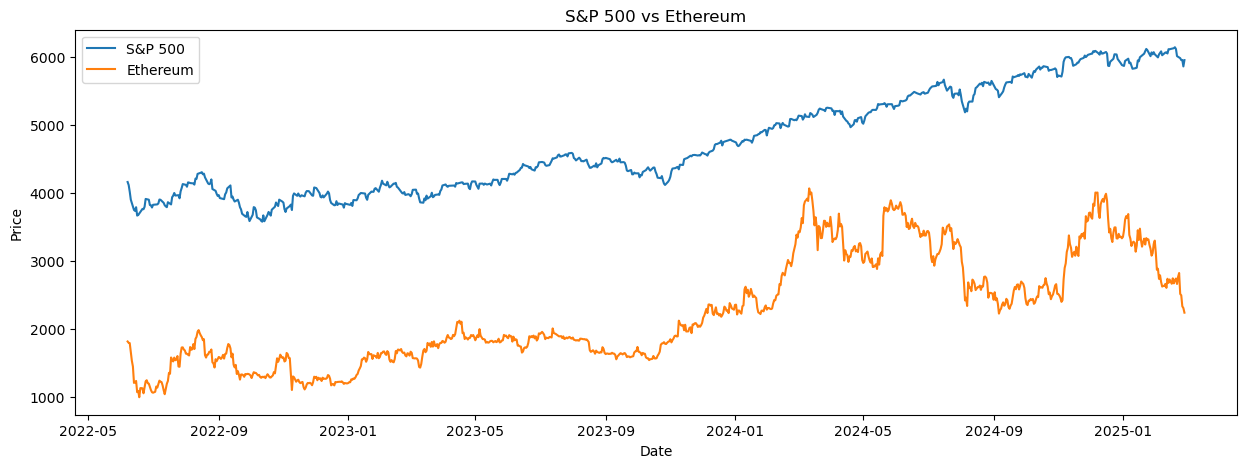

In [14]:
# plot the 'clean' data
plt.figure(figsize=(15, 5))
plt.plot(sp_clean["Date"], sp_clean["Price"], label="S&P 500")
plt.plot(eth_clean["Date"], eth_clean["Price"], label="Ethereum")
plt.title("S&P 500 vs Ethereum")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

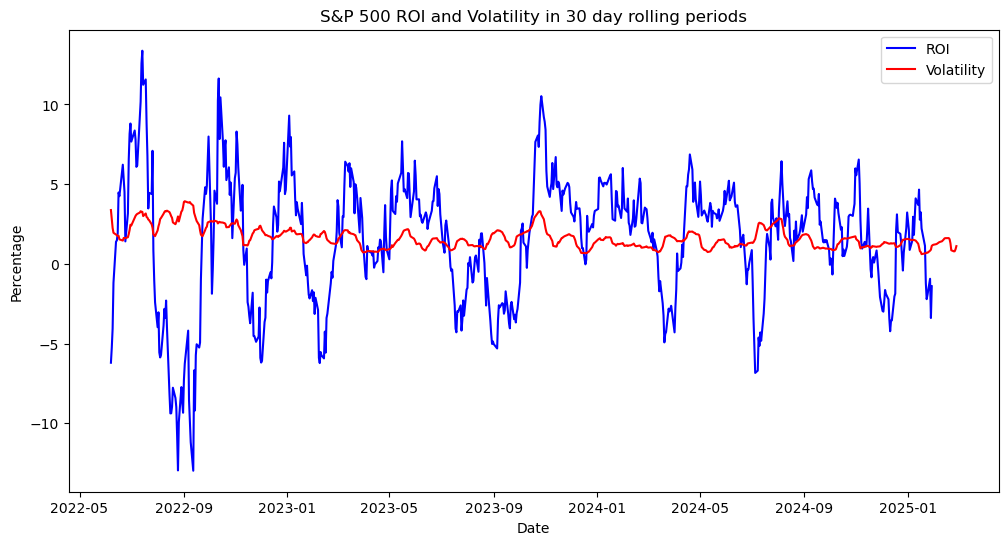

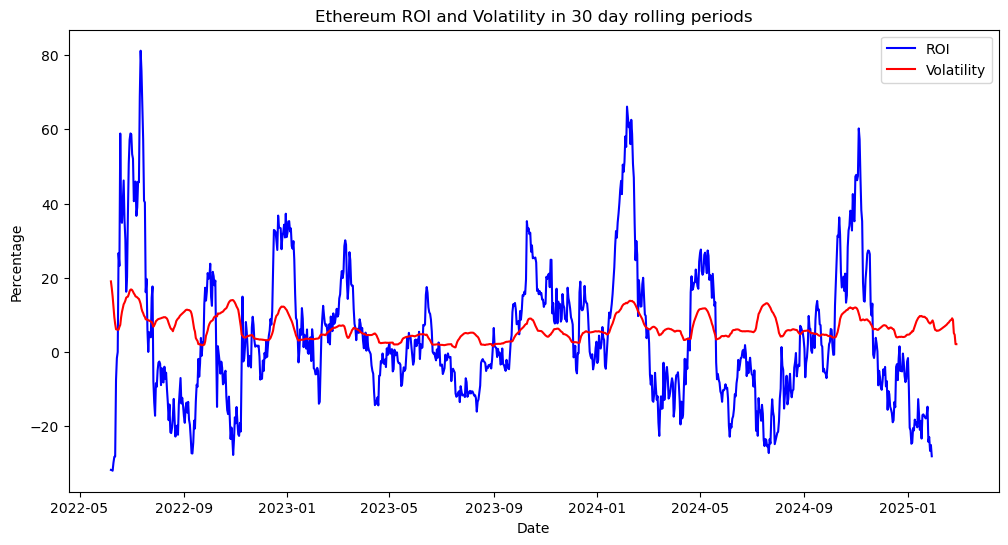

+--------------------+--------------------+--------------------+--------------------+---------------------+
|       Metric       |        Mean        |       Median       |        Max         |         Min         |
+--------------------+--------------------+--------------------+--------------------+---------------------+
|    ROI S&P 500     | 1.5130654059830897 | 2.2128309316703314 | 13.369635762113566 | -12.976321096922197 |
| Volatility S&P 500 | 1.6444196370200448 | 1.5228726340862688 | 3.927029967629058  |  0.6094603881813879 |
+--------------------+--------------------+--------------------+--------------------+---------------------+
+---------------------+-------------------+---------------------+--------------------+--------------------+
|        Metric       |        Mean       |        Median       |        Max         |        Min         |
+---------------------+-------------------+---------------------+--------------------+--------------------+
|     ROI Ethereum    | 3.99

In [ ]:
# 2. Summarizing Data into Rolling Periods


def summarize_data(data, len_period):
    '''
        Returns DF with rolling time horizons
        data: DataFrame
        len_period: int
    '''
    def calculate_ROI(start, end): 
        '''ROI = Net Profit / Cost of the investment * 100'''
        return (end-start)/start * 100
    
    def calculate_Volatility(data):
        return data.std()/data.mean() * 100
    
    roi_list = []
    vol_list = []

    for i, row in data.iterrows():
        current_date = row["Date"]
        current_value = row["Price"]

        # Find the nearest date that is at least `len_period` days ahead
        future_data = data[data["Date"] >= current_date + pd.Timedelta(days=len_period)]

        if not future_data.empty:
            future_value = future_data.iloc[0]["Price"]  # First valid future price
            roi = calculate_ROI(current_value, future_value)
        else:
            roi = None  # No future data available

        # Get all values within the next `len_period` days
        period_data = data[(data["Date"] >= current_date) & 
                           (data["Date"] < current_date + pd.Timedelta(days=len_period))]

        if len(period_data) > 1:
            volatility = calculate_Volatility(period_data["Price"])
        else:
            volatility = None  # Not enough data points

        roi_list.append(roi)
        vol_list.append(volatility)

    data["ROI"] = roi_list
    data["Volatility"] = vol_list
    
    return data[["Date", "ROI", "Volatility"]]


def plot_summary_data(data, title):
    '''
        Plots the data
        data: DataFrame
        title: str
    '''
    plt.figure(figsize=(12, 6))
    
    plt.plot(data["Date"], data["ROI"], label="ROI", color="blue")
    plt.plot(data["Date"], data["Volatility"], label="Volatility", color="red")
    
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Percentage")
    
    plt.legend()
    plt.show()
    
def table_summary_data(data1, data2, period):
    '''
        Returns a table with the data
        data1: DataFrame
        period: int
        data2: DataFrame
    '''
    # Create a PrettyTable object
    table = PrettyTable()
    table.field_names = ["Period", "Metric", "Value"]
    for i in range(period - 1, len(data1)):
        table.add_row([i, data1[i], data2[i]])

    # Print the table
    print(table)
    
def assess_summary(data, asset):
    '''
        Assess the summary
        data: DataFrame
        asset: str
    '''
    # Assess the summary
    table= PrettyTable()
    table.field_names = ["Metric", "Mean", "Median", "Max", "Min"]
    table.add_row([f"ROI {asset}", data["ROI"].mean(), data["ROI"].median(), data["ROI"].max(), data["ROI"].min()])
    table.add_row([f"Volatility {asset}", data["Volatility"].mean(), data["Volatility"].median(), data["Volatility"].max(), data["Volatility"].min()])
    print(table)
    
def main_summary(period):
    '''
        period: int
    '''
    #
    SP_summary = summarize_data(sp_clean, period)
    ETH_summary = summarize_data(eth_clean, period)
    
    # Plot the data
    plot_summary_data(SP_summary, f"S&P 500 ROI and Volatility in {period} day rolling periods")
    plot_summary_data(ETH_summary, f"Ethereum ROI and Volatility in {period} day rolling periods")
    
    # Table the data
    #table_summary_data(ROI_SP, volatility_SP, period)
   # table_summary_data(ROI_ETH, volatility_ETH, period)
    
    
    # Assess the summary
    assess_summary(SP_summary, "S&P 500")
    assess_summary(ETH_summary, "Ethereum")
    

main_summary(30)

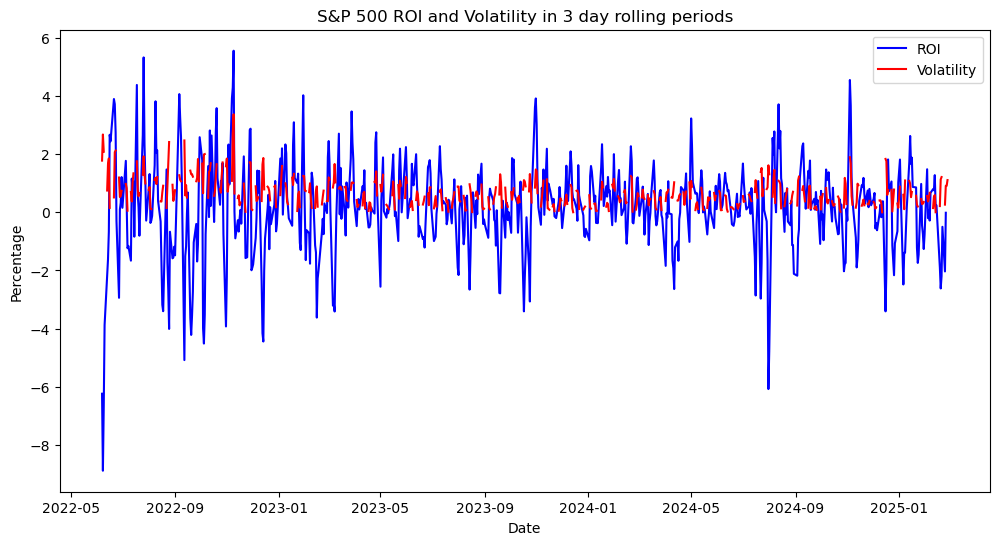

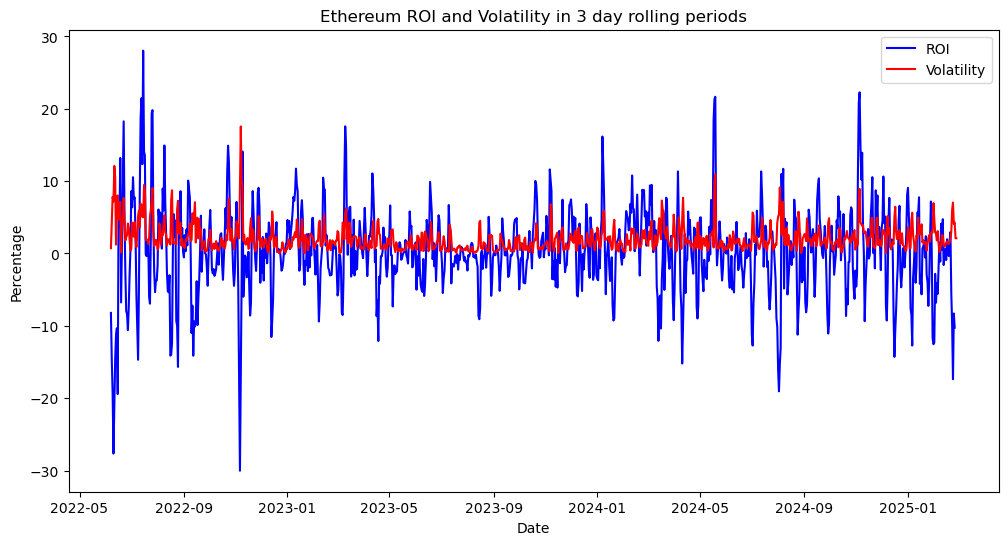

+--------------------+---------------------+---------------------+--------------------+----------------------+
|       Metric       |         Mean        |        Median       |        Max         |         Min          |
+--------------------+---------------------+---------------------+--------------------+----------------------+
|    ROI S&P 500     | 0.15404037362805786 | 0.23889729398620352 | 5.566922853248034  |  -8.896026745906607  |
| Volatility S&P 500 |  0.6666065058478114 |  0.5706780010945423 | 3.3801324189011828 | 0.001869672889536151 |
+--------------------+---------------------+---------------------+--------------------+----------------------+
+---------------------+---------------------+---------------------+--------------------+---------------------+
|        Metric       |         Mean        |        Median       |        Max         |         Min         |
+---------------------+---------------------+---------------------+--------------------+---------------------+
|

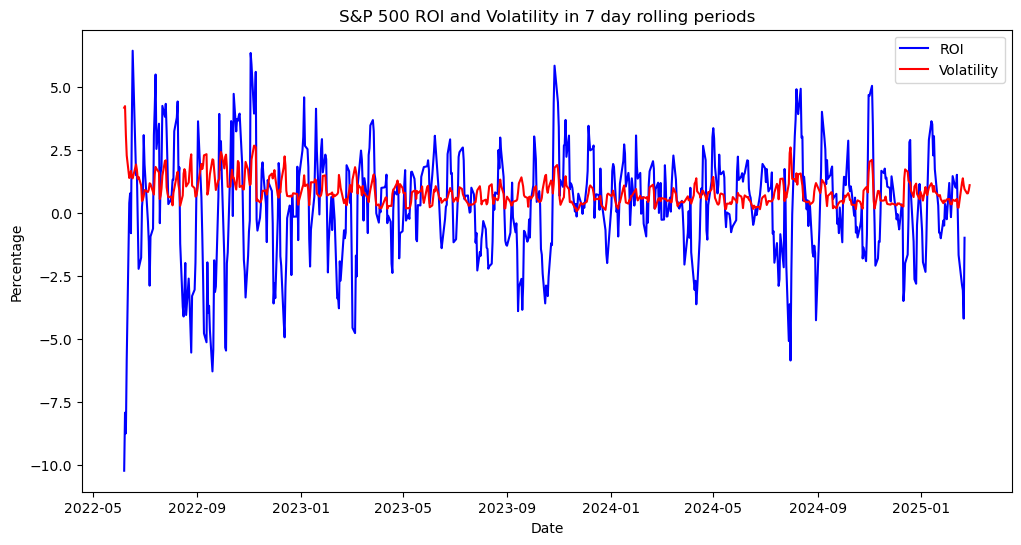

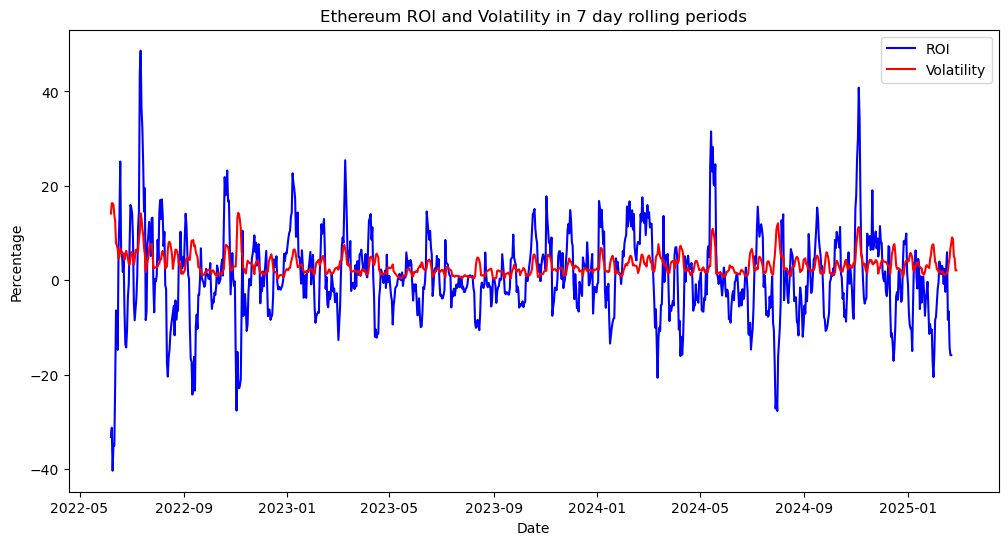

+--------------------+---------------------+--------------------+-------------------+---------------------+
|       Metric       |         Mean        |       Median       |        Max        |         Min         |
+--------------------+---------------------+--------------------+-------------------+---------------------+
|    ROI S&P 500     | 0.29961135153821905 | 0.4363610314674708 | 6.446539169052248 | -10.219483353682577 |
| Volatility S&P 500 |  0.851299954325246  | 0.7211862007771512 | 4.248602801493575 | 0.08208673951586881 |
+--------------------+---------------------+--------------------+-------------------+---------------------+
+---------------------+--------------------+---------------------+--------------------+--------------------+
|        Metric       |        Mean        |        Median       |        Max         |        Min         |
+---------------------+--------------------+---------------------+--------------------+--------------------+
|     ROI Ethereum    | 0

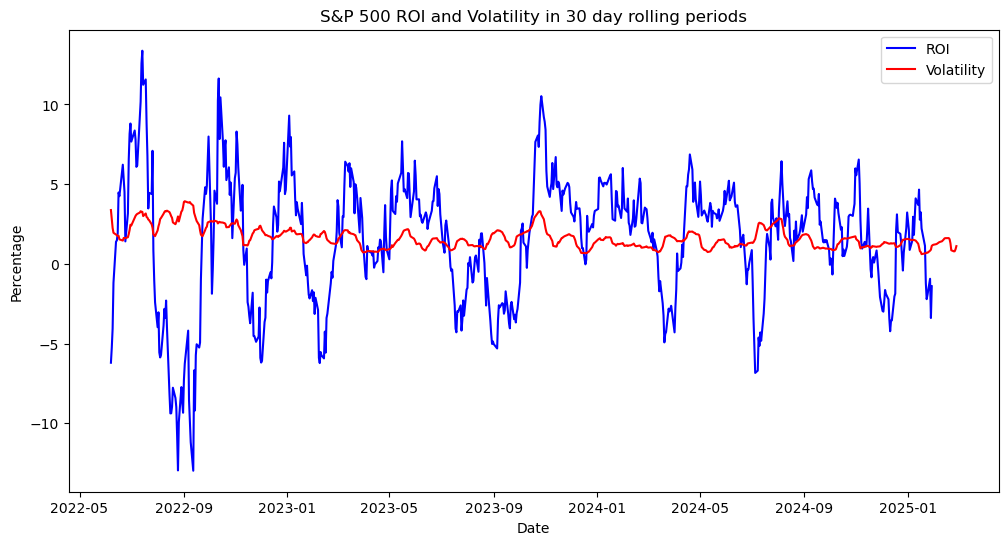

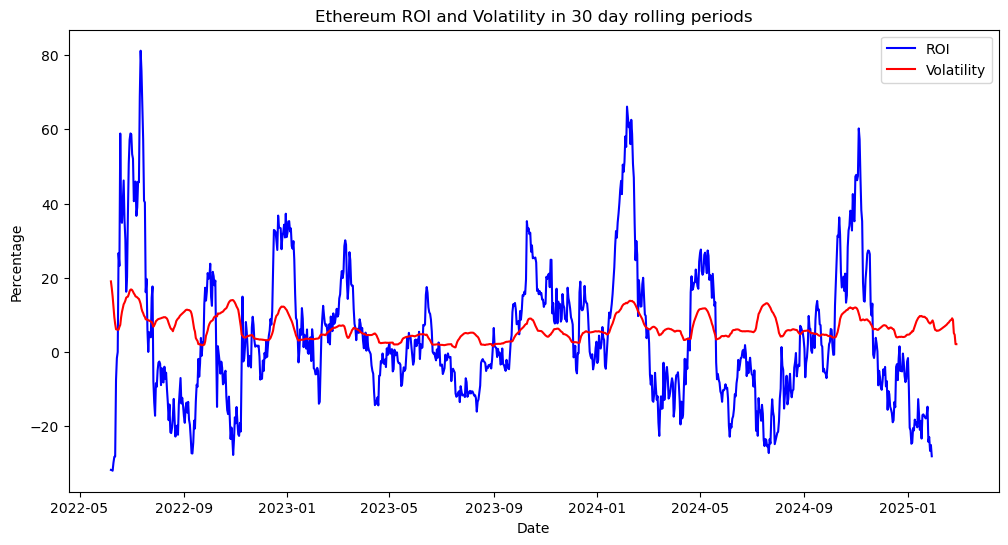

+--------------------+--------------------+--------------------+--------------------+---------------------+
|       Metric       |        Mean        |       Median       |        Max         |         Min         |
+--------------------+--------------------+--------------------+--------------------+---------------------+
|    ROI S&P 500     | 1.5130654059830897 | 2.2128309316703314 | 13.369635762113566 | -12.976321096922197 |
| Volatility S&P 500 | 1.6444196370200448 | 1.5228726340862688 | 3.927029967629058  |  0.6094603881813879 |
+--------------------+--------------------+--------------------+--------------------+---------------------+
+---------------------+-------------------+---------------------+--------------------+--------------------+
|        Metric       |        Mean       |        Median       |        Max         |        Min         |
+---------------------+-------------------+---------------------+--------------------+--------------------+
|     ROI Ethereum    | 3.99

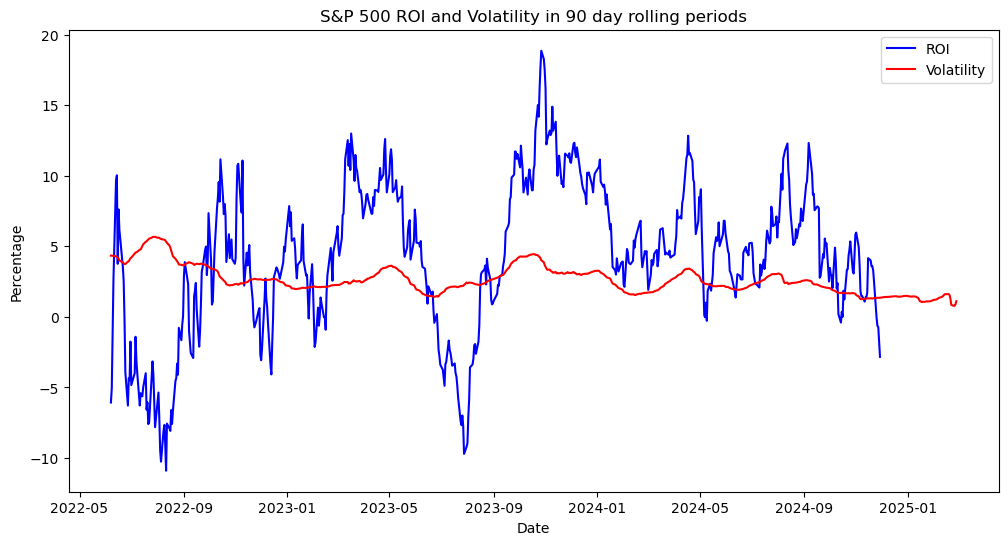

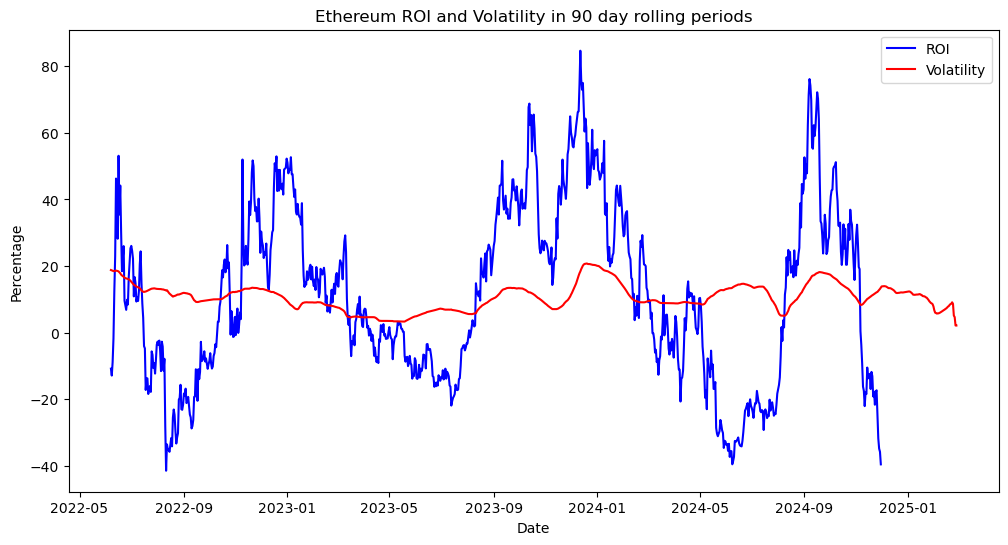

+--------------------+--------------------+--------------------+-------------------+---------------------+
|       Metric       |        Mean        |       Median       |        Max        |         Min         |
+--------------------+--------------------+--------------------+-------------------+---------------------+
|    ROI S&P 500     | 4.309361716478318  | 4.474704753800492  | 18.86616942368551 | -10.902556764838012 |
| Volatility S&P 500 | 2.6361489940738387 | 2.4355333747739847 | 5.676662327559391 |  0.7848503901945313 |
+--------------------+--------------------+--------------------+-------------------+---------------------+
+---------------------+--------------------+-------------------+--------------------+---------------------+
|        Metric       |        Mean        |       Median      |        Max         |         Min         |
+---------------------+--------------------+-------------------+--------------------+---------------------+
|     ROI Ethereum    | 11.3718029

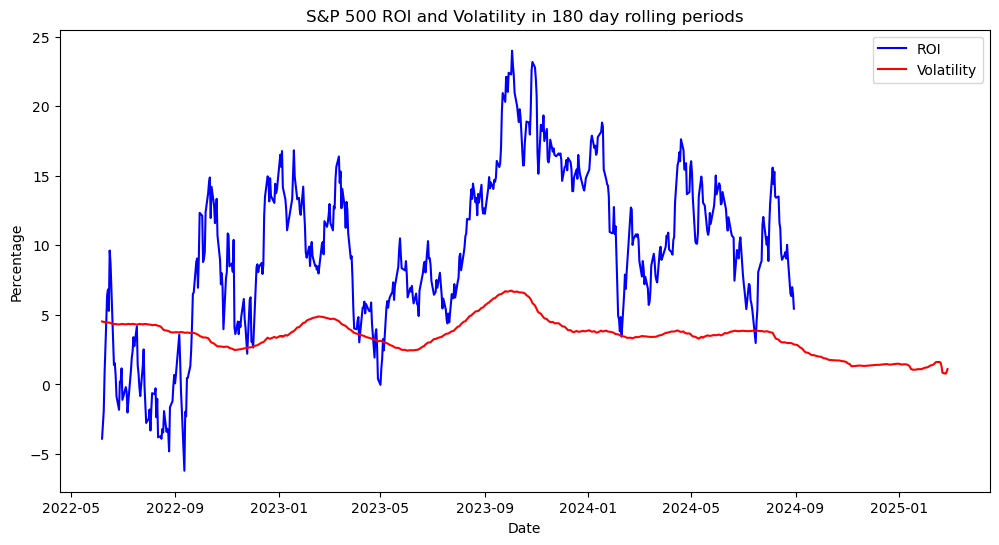

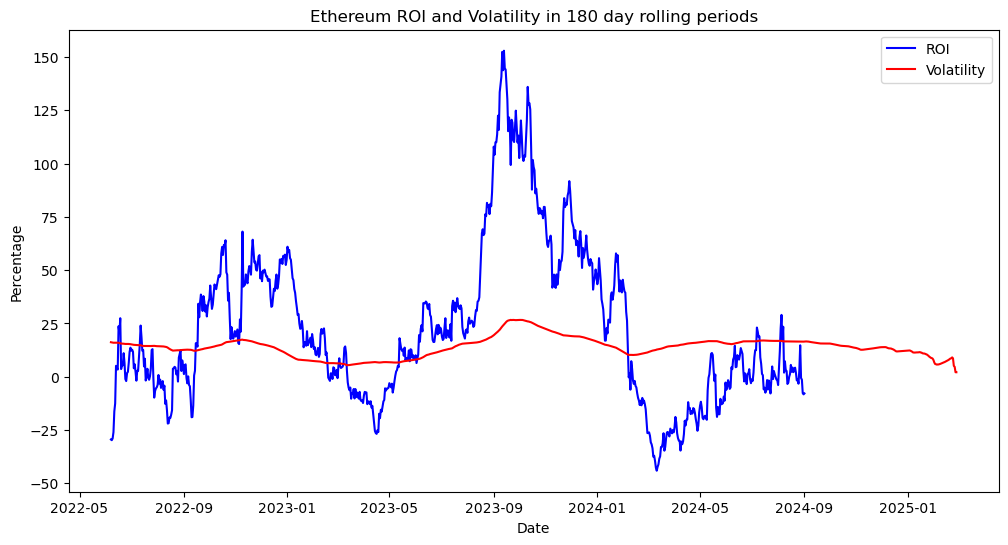

+--------------------+-------------------+-------------------+-------------------+---------------------+
|       Metric       |        Mean       |       Median      |        Max        |         Min         |
+--------------------+-------------------+-------------------+-------------------+---------------------+
|    ROI S&P 500     | 9.645249835631995 | 9.717575563325743 | 23.98231448533499 | -6.1952457297447125 |
| Volatility S&P 500 | 3.490048332718901 | 3.578599342093081 | 6.747967435468693 |  0.7848503901945313 |
+--------------------+-------------------+-------------------+-------------------+---------------------+
+---------------------+--------------------+--------------------+-------------------+--------------------+
|        Metric       |        Mean        |       Median       |        Max        |        Min         |
+---------------------+--------------------+--------------------+-------------------+--------------------+
|     ROI Ethereum    | 22.720692996023754 | 13.8

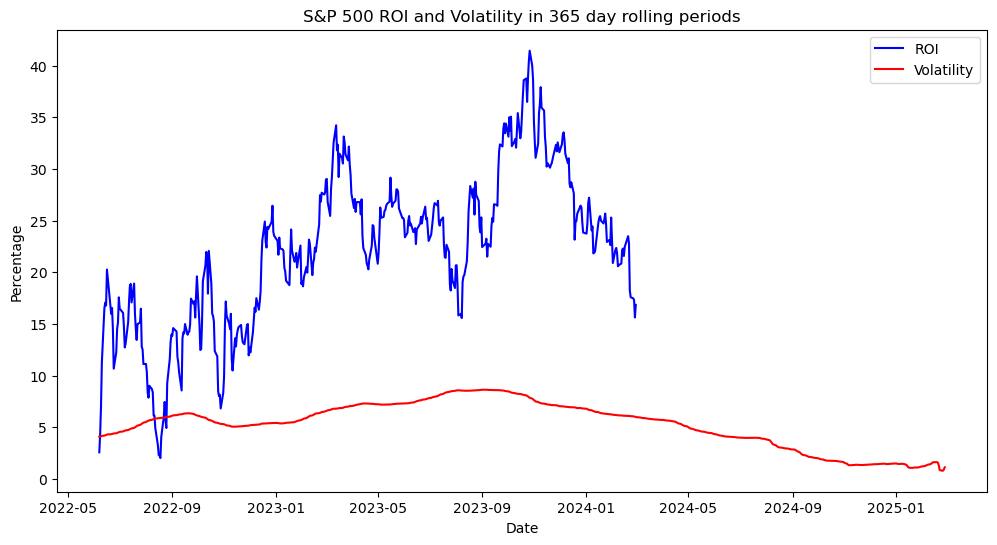

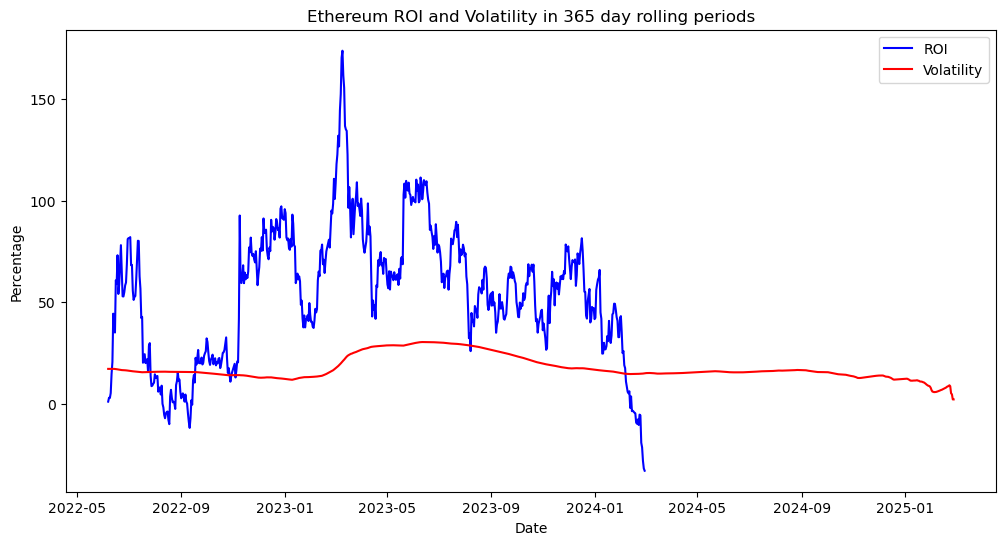

+--------------------+-------------------+--------------------+-------------------+--------------------+
|       Metric       |        Mean       |       Median       |        Max        |        Min         |
+--------------------+-------------------+--------------------+-------------------+--------------------+
|    ROI S&P 500     |  22.1496523612818 | 22.724725701787687 | 41.43785960455341 | 2.0068911745344082 |
| Volatility S&P 500 | 5.321715206577724 | 5.699296361106219  | 8.628965489783017 | 0.7848503901945313 |
+--------------------+-------------------+--------------------+-------------------+--------------------+
+---------------------+--------------------+--------------------+--------------------+--------------------+
|        Metric       |        Mean        |       Median       |        Max         |        Min         |
+---------------------+--------------------+--------------------+--------------------+--------------------+
|     ROI Ethereum    | 54.75633091316065  | 5

In [8]:
def compare_periods(periods):
    '''
        Compares the periods
        periods: list
    '''
    for period in periods:
        main_summary(period)
        

compare_periods([3,7,30,90,180,365])

In [ ]:
# 3. How much to Invest
# Proper betsizing is important as it can help to manage risk (preserve capital) and maximize returns.

def calculate_betsizing(price_data, period):
    
    return[ammount, period]

In [ ]:
def calc_portfolio_roi(percentage_eth, period):
    '''
        Returns the average ROI for a given asset allocation and period.
        
        percentage_eth: float - Allocation to ETH (between 0 and 1)
        period: int - Time horizon (days)
        
        Returns:
        float - Average ROI in percentage
    '''
    def calculate_average_roi(data, period):
        return data.rolling(window=period).apply(lambda x: (x[-1] - x[0]) / x[0] * 100, raw=True)

    # Calculate average ROI for both assets
    avg_roi_eth = calculate_average_roi(eth_clean["Price"], period)
    avg_roi_sp = calculate_average_roi(sp_clean["Price"], period)

    # Weighted average ROI based on allocation
    weighted_avg_roi = avg_roi_eth * percentage_eth + avg_roi_sp * (1 - percentage_eth)

    return weighted_avg_roi.mean()

In [ ]:
# > *Disclaimer:*
# > this is the correct function to calculate the ROI anyhow, the function is incredibly slow and 
# > needs which is the reason why the calc_portfolio_roi funciton above is using rolling windows .

# def calc_portfolio_roi(percentage_eth, period):
    
#     eth_summary = summarize_data(eth_clean, period)
#     sp_summary = summarize_data(sp_clean, period)
    
#     # Calculate weighted ROI
#     weighted_avg_roi = eth_summary["ROI"].mean() * percentage_eth + sp_summary["ROI"].mean() * (1 - percentage_eth)
    
#     return weighted_avg_roi

In [ ]:
# @Daniel please run us through the code below
import numpy as np

def optimize_allocation(calc_portfolio_roi, initial_percentage_eth=0.5, initial_period=30, 
                        learning_rate_eth=0.01, learning_rate_period=5.0, 
                        max_iterations=100, tolerance=1e-6):
    """
    Optimizes asset allocation and period using gradient ascent.
    
    calc_portfolio_roi: function - Function that calculates average ROI.
    initial_percentage_eth: float - Initial allocation to ETH (0 to 1).
    initial_period: int - Initial time horizon (days).
    learning_rate_eth: float - Step size for ETH allocation.
    learning_rate_period: float - Step size for time period.
    max_iterations: int - Maximum number of iterations.
    tolerance: float - Convergence criterion.
    """
    percentage_eth = initial_percentage_eth
    period = initial_period
    max_period = 2 * 365  # Max period of 2 years
    min_period = 1  # Minimum period of 1 day
    
    for _ in range(max_iterations):
        # Compute current ROI
        current_roi = calc_portfolio_roi(percentage_eth, period)
        
        # Compute gradients via small perturbations
        delta_eth = 1e-3
        delta_period = 1  # Period should be adjusted in whole days

        grad_eth = (calc_portfolio_roi(min(percentage_eth + delta_eth, 1), period) - current_roi) / delta_eth
        grad_period = (calc_portfolio_roi(percentage_eth, min(period + delta_period, max_period)) - current_roi) / delta_period

        # Normalize gradients separately
        grad_eth /= max(abs(grad_eth), 1e-6)  # Avoid division by zero
        grad_period /= max(abs(grad_period), 1e-6)  # Separate normalization

        # Update variables with separate learning rates
        percentage_eth = np.clip(percentage_eth + learning_rate_eth * grad_eth, 0.01, 0.99)
        period = int(np.clip(period + learning_rate_period * grad_period, min_period, max_period))
        
        print(f"ETH: {percentage_eth:.2f}, Period: {period}, ROI: {current_roi:.2f}")

        # Convergence check
        if abs(grad_eth) < tolerance and abs(grad_period) < tolerance:
            break
    
    return percentage_eth, period


In [ ]:
optimize_allocation(calc_portfolio_roi, initial_percentage_eth=0.5, initial_period=305)

ETH: 0.51, Period: 310, ROI: 30.27
ETH: 0.52, Period: 315, ROI: 31.05
ETH: 0.53, Period: 320, ROI: 31.79
ETH: 0.54, Period: 325, ROI: 32.59
ETH: 0.55, Period: 330, ROI: 33.47
ETH: 0.56, Period: 335, ROI: 34.40
ETH: 0.57, Period: 340, ROI: 35.39
ETH: 0.58, Period: 345, ROI: 36.50
ETH: 0.59, Period: 350, ROI: 37.63
ETH: 0.60, Period: 355, ROI: 38.72
ETH: 0.61, Period: 360, ROI: 39.92
ETH: 0.62, Period: 365, ROI: 41.11
ETH: 0.63, Period: 370, ROI: 42.37
ETH: 0.64, Period: 375, ROI: 43.63
ETH: 0.65, Period: 380, ROI: 44.89
ETH: 0.66, Period: 385, ROI: 46.12
ETH: 0.67, Period: 390, ROI: 47.29
ETH: 0.68, Period: 395, ROI: 48.49
ETH: 0.69, Period: 400, ROI: 49.67
ETH: 0.70, Period: 405, ROI: 50.84
ETH: 0.71, Period: 410, ROI: 52.03
ETH: 0.72, Period: 415, ROI: 53.39
ETH: 0.73, Period: 420, ROI: 54.80
ETH: 0.74, Period: 425, ROI: 56.21
ETH: 0.75, Period: 430, ROI: 57.68
ETH: 0.76, Period: 435, ROI: 59.14
ETH: 0.77, Period: 440, ROI: 60.62
ETH: 0.78, Period: 445, ROI: 62.17
ETH: 0.79, Period: 4

KeyboardInterrupt: 

In [17]:
# Define the periods to evaluate
periods = range(1, 600)  # From 1 day to 365 days

# Calculate the ROI for each period
roi_values = [calc_portfolio_roi(0.99, period) for period in periods]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(periods, roi_values, label="ROI with 99% ETH allocation", color="blue")
plt.title("ROI with 99% ETH Allocation Over Different Period Lengths")
plt.xlabel("Period Length (days)")
plt.ylabel("ROI (%)")
plt.legend()
plt.show()

KeyboardInterrupt: 